# Install

In [1]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks, RandomUnderSampler   # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier

import pickle

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Variables

In [3]:
# Number of cores being used 
n_jobs = 10

In [4]:
# Random State
random_state = 14

# General Functions

In [5]:
# Stopwatch to profile function runtimes
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime

In [6]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con

# Data Cleaning

In [7]:
# Read in data
df = pd.read_csv('/data/home/bt211037/dissertation/feats_selected_dataset.tsv',
                   sep='\t', header=0, index_col=0)

### Convert categorical columns to integers

In [8]:
# Get the column names of the continuous and categorical data
cat, con = cat_con_cols(df)  

# Convert categorical cols values from floats to integers 
df[cat] = df[cat].astype('Int64')  

### Separate categorical and Continuous features in dataframe¶

This makes indexing certain features in later processess easier. Continuous features are the first columns followed by categorical.


In [9]:
df = pd.concat([df[con], df[cat]], axis=1, join="inner")

In [10]:
# Column indexes for categorical and continuous features
# Important to exclude target feature - thryoid_cancer
categorical_indexes = [i for i, x in enumerate(df.columns[0:44]) if x in cat]
continuous_indexes = [i for i, x in enumerate(df.columns) if x in con]


# Test Train Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=df['thyroid_cancer'])


# Pipeline

### Imputation
Testing three types of imputation:
- Simple Imputation
- Multiple imputation
- KNN imputation

In [12]:
# Simple imputer 
simp_imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(missing_values=np.nan, strategy='median'),
             continuous_indexes),

            ('cat', SimpleImputer(missing_values=np.nan, strategy='constant',
                                  fill_value=4444),
             categorical_indexes)

        ])


In [13]:
# Multiple imputation with iterative imputer
imputer = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(initial_strategy='median',
                                 max_iter=5,
                                 random_state=random_state), 
         continuous_indexes),
        
        ('cat', IterativeImputer(estimator=RidgeClassifier(),
                                 initial_strategy='most_frequent',
                                 max_iter=10, 
                                 random_state=random_state), 
         categorical_indexes)
    
    ])


In [14]:
# KNN imputer
knn_imp = KNNImputer(n_neighbors=1)

### Feature Encoding and Normalisation

In [15]:
# Column transformer to carry out normalisation and onehot encoding
enc_norm = ColumnTransformer(
    transformers=[('normalisation', MinMaxScaler(), 
                   continuous_indexes),
                 ('onehot', OneHotEncoder(drop='if_binary',
                                          handle_unknown='ignore',
                                          sparse=False), 
                   categorical_indexes)], 
    
    remainder='passthrough')

### Sampling Methods
Tomek Links Undersampling and SMOTENC oversampling will be used to address class imbalance. This will be compared with using no sampling methods.

In [16]:
# Tomek Links undersampling
tl = TomekLinks(sampling_strategy='majority')

In [17]:
# SMOTE oversampling
smote = SMOTENC(random_state=random_state,
                categorical_features=categorical_indexes,
                sampling_strategy=1)

### Predictive model
Will be testing the sklearn MLP classifier.

In [18]:
# MLP
mlp_model = MLPClassifier(random_state=random_state)

# Random Undersampling
Undersample the majority class in the dataset to provide a smaller dataset for hyperparamter tuning. Training on this smaller dataset even seems to give better results than on the full dataset.

Reduces the data from ~300,000 to ~6,000 rows/samples.

In [19]:
# Configure random undersampler
rus = RandomUnderSampler(sampling_strategy=0.1,
                         random_state=random_state)


In [20]:
# Create the dataset used for hyperparamter tuning and training
X_res, y_res = rus.fit_resample(X_train, y_train.astype('float64'))


In [21]:
X_res

,Whole body fat-free mass|x23101_0_0,Whole body water mass|x23102_0_0,Leg fat percentage (right)|x23111_0_0,Leg predicted mass (right)|x23114_0_0,Leg fat percentage (left)|x23115_0_0,Leg fat-free mass (left)|x23117_0_0,Arm fat percentage (right)|x23119_0_0,Arm fat-free mass (right)|x23121_0_0,Arm predicted mass (right)|x23122_0_0,Arm fat percentage (left)|x23123_0_0,...,Illness injury bereavement stress in last 2 years|x6145_0_0,Attendance/disability/mobility allowance|x6146_0_0,Medication for pain relief constipation heartburn|x6154_0_0,Types of transport used (excluding work)|x6162_0_0,Illnesses of siblings|x20111_0_0,Spirometry QC measure|x20255_0_0,Genetic sex|x22001_0_0,Genetic kinship to other participants|x22021_0_0,Above moderate/vigorous/walking recommendation|x22036_0_0,medication_cbi
0,40.1,29.4,38.0,6.3,38.6,6.5,29.1,2.1,1.9,30.9,...,0,0,-1,1,3,<NA>,0,1,1,-1
1,58.6,42.9,11.7,8.8,11.8,9.0,13.0,3.1,2.9,11.8,...,0,0,-1,1,8,1,1,0,1,-1
2,37.9,27.7,35.7,6.2,36.6,6.3,33.4,1.8,1.6,32.4,...,0,0,-1,1,9,1,0,0,1,-1
3,38.3,28.0,37.7,6.0,36.7,6.4,32.2,1.8,1.7,31.6,...,0,0,-1,1,8,1,0,0,1,-1
4,52.3,38.3,39.4,7.9,39.0,8.3,32.5,2.7,2.5,32.5,...,2,0,1,1,<NA>,<NA>,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,39.4,28.8,23.4,6.3,26.4,6.3,11.2,2.0,1.9,13.7,...,0,0,2,2,<NA>,2,0,1,1,-1
6035,40.2,29.4,33.4,6.3,34.4,6.5,25.6,2.0,1.8,25.9,...,0,0,3,1,0,<NA>,0,1,1,-1
6036,38.6,28.3,41.5,6.1,41.7,6.4,37.0,1.9,1.7,36.1,...,0,0,1,1,12,<NA>,0,0,<NA>,1
6037,35.9,26.3,33.3,5.8,34.0,6.0,28.4,1.6,1.5,28.7,...,0,0,-1,1,0,<NA>,0,0,<NA>,-1


# Simple Imputation

### MLP with sampling

In [26]:
simp_mlp_pipe = imbpipeline(steps = [('imputer', simp_imputer),
                                    ('enc_norm', enc_norm),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', mlp_model)])

In [37]:
# Parameter to search
simp_mlp_search_grid = {
    'model__hidden_layer_sizes': [(100), (100,100),
                                  (100, 100, 100)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter':[500]
}




In [28]:
# Random search configurations
simp_mlp_hyper_search = GridSearchCV(estimator=simp_mlp_pipe,
                                    param_grid=simp_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [29]:
%%memit

t=Stopwatch()

simp_mlp_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

1127.055542984046
peak memory: 674.64 MiB, increment: 58.18 MiB


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
# Look at results of search
simp_mlp_res = pd.DataFrame(simp_mlp_hyper_search.cv_results_)

In [31]:
# Find the optimum number of features
simp_mlp_hyper_search.best_params_

{'model__activation': 'tanh',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': (100, 100),
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'sgd'}

In [32]:
simp_mlp_res['mean_test_score'].loc[simp_mlp_res['rank_test_score'] == 1]

42    0.233116
46    0.233116
Name: mean_test_score, dtype: float64

### MLP with no sampling

In [33]:
simp_mlp_ns_pipe = imbpipeline(steps = [('imputer', simp_imputer),
                                        ('enc_norm', enc_norm),
                                        ('model', mlp_model)])

In [38]:
# Random search configurations
simp_mlp_ns_hyper_search = GridSearchCV(estimator=simp_mlp_ns_pipe,
                                    param_grid=simp_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [39]:
%%memit

t=Stopwatch()

simp_mlp_ns_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

140.17653453699313
peak memory: 613.92 MiB, increment: 3.03 MiB


In [40]:
# Look at results of search
simp_mlp_ns_res = pd.DataFrame(simp_mlp_ns_hyper_search.cv_results_)

In [41]:
# Find the optimum number of features
simp_mlp_ns_hyper_search.best_params_

{'model__activation': 'tanh',
 'model__alpha': 0.0001,
 'model__hidden_layer_sizes': (100, 100, 100),
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'adam'}

In [42]:
simp_mlp_ns_res['mean_test_score'].loc[simp_mlp_ns_res['rank_test_score'] == 1]



9     0.19639
11    0.19639
Name: mean_test_score, dtype: float64

# Multiple Imputation

### MLP with sampling

In [43]:
mult_mlp_pipe = imbpipeline(steps = [('imputer', imputer),
                                    ('enc_norm', enc_norm),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', mlp_model)])

In [44]:
# Parameter to search
mult_mlp_search_grid = {
    'model__hidden_layer_sizes': [(100), (100,100),
                                  (100, 100, 100)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter':[500]
}



In [45]:
# Random search configurations
mult_mlp_hyper_search = GridSearchCV(estimator=mult_mlp_pipe,
                                    param_grid=mult_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [46]:
%%memit

t=Stopwatch()

mult_mlp_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_i

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_i

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/o

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterati

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterati

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_i

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterati

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stoc

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_i

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_ne

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

492.04819689691067
peak memory: 654.44 MiB, increment: 40.52 MiB


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [47]:
# Look at results of search
mult_mlp_res = pd.DataFrame(mult_mlp_hyper_search.cv_results_)

In [48]:
# Find the optimum number of features
mult_mlp_hyper_search.best_params_

{'model__activation': 'relu',
 'model__alpha': 0.0001,
 'model__hidden_layer_sizes': 100,
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'sgd'}

In [49]:
mult_mlp_res['mean_test_score'].loc[mult_mlp_res['rank_test_score'] == 1]

24    0.24108
26    0.24108
Name: mean_test_score, dtype: float64

### MLP with no sampling

In [50]:
ns_mult_mlp_pipe = imbpipeline(steps = [('imputer', imputer),
                                    ('enc_norm', enc_norm),
                                    ('model', mlp_model)])

In [51]:
# Parameter to search
ns_mult_mlp_search_grid = {
    'model__hidden_layer_sizes': [(100), (100,100),
                                  (100, 100, 100)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter':[500]
}

In [52]:
# Random search configurations
ns_mult_mlp_hyper_search = GridSearchCV(estimator=ns_mult_mlp_pipe,
                                    param_grid=ns_mult_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [53]:
%%memit

t=Stopwatch()

ns_mult_mlp_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_e

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preproces

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterati

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterati

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/impute/_i

156.21681385184638
peak memory: 645.39 MiB, increment: 0.95 MiB


In [54]:
# Look at results of search
ns_mult_mlp_res = pd.DataFrame(ns_mult_mlp_hyper_search.cv_results_)

In [55]:
# Find the optimum number of features
ns_mult_mlp_hyper_search.best_params_

{'model__activation': 'relu',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': (100, 100),
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'adam'}

In [57]:
ns_mult_mlp_res['mean_test_score'].loc[ns_mult_mlp_res['rank_test_score'] == 1]

41    0.191184
43    0.191184
Name: mean_test_score, dtype: float64

# KNN Imputation

### SVM with Sampling

In [22]:
knn_mlp_pipe = imbpipeline(steps = [('imputer', knn_imp),
                                    ('enc_norm', enc_norm),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', mlp_model)])

In [23]:
# Parameter to search
knn_mlp_search_grid = {
    'model__hidden_layer_sizes': [(100), (100,100),
                                  (100, 100, 100)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter':[500]
}

In [24]:
# Grid search params
knn_mlp_hyper_search = GridSearchCV(estimator=knn_mlp_pipe,
                                    param_grid=knn_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [25]:
%%memit

# Grid search

t=Stopwatch()

knn_mlp_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all z

660.571028442122
peak memory: 971.62 MiB, increment: 387.81 MiB


/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
# Look at results of search
knn_mlp_res = pd.DataFrame(knn_mlp_hyper_search.cv_results_)

In [27]:
# Find the optimum number of features
knn_mlp_hyper_search.best_params_

{'model__activation': 'tanh',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': 100,
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'sgd'}

In [28]:
knn_mlp_res['mean_test_score'].loc[knn_mlp_res['rank_test_score'] == 1]

12    0.239324
Name: mean_test_score, dtype: float64

### SVM with no sampling

In [29]:
ns_knn_mlp_pipe = imbpipeline(steps = [('imputer', knn_imp),
                                    ('enc_norm', enc_norm),
                                    ('model', mlp_model)])

In [30]:
# Parameter to search
ns_knn_mlp_search_grid =  {
    'model__hidden_layer_sizes': [(100), (100,100),
                                  (100, 100, 100)],
    'model__activation': ['tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
    'model__max_iter':[500]
}

In [31]:
# Grid search params
ns_knn_mlp_hyper_search = GridSearchCV(estimator=ns_knn_mlp_pipe,
                                    param_grid=ns_knn_mlp_search_grid,
                                    cv=3,
                                    n_jobs=n_jobs,
                                    scoring='f1')

In [32]:
%%memit

# Grid search

t=Stopwatch()

ns_knn_mlp_hyper_search.fit(X_res, y_res)

print(t.stop())

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17] during transform. These unknown categories will be encoded as all zeros
 

244.15708666783758
peak memory: 998.02 MiB, increment: 363.19 MiB


In [33]:
# Look at results of search
ns_knn_mlp_res = pd.DataFrame(ns_knn_mlp_hyper_search.cv_results_)

In [34]:
# Find the optimum number of features
ns_knn_mlp_hyper_search.best_params_

{'model__activation': 'relu',
 'model__alpha': 0.05,
 'model__hidden_layer_sizes': 100,
 'model__learning_rate': 'constant',
 'model__max_iter': 500,
 'model__solver': 'adam'}

In [35]:
ns_knn_mlp_res['mean_test_score'].loc[ns_knn_mlp_res['rank_test_score'] == 1]

37    0.196013
39    0.196013
Name: mean_test_score, dtype: float64

# Training

### Train on undersampled dataset



In [59]:
# Optimal Model
o_mlp_model = MLPClassifier(random_state=random_state,
                            activation='relu',
                            alpha=0.05,
                            hidden_layer_sizes=100,
                            learning_rate='constant',
                            max_iter=500,
                            solver='adam')

In [60]:
knn_o_mlp_pipe = imbpipeline(steps = [('imputer', knn_imp),
                                    ('enc_norm', enc_norm),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', o_mlp_model)])

In [61]:
%%memit

# Model Training
t=Stopwatch()

knn_o_mlp_pipe.fit(X_res, y_res.values.ravel())

print(t.stop())

38.0163242360577
peak memory: 1114.99 MiB, increment: 363.12 MiB


In [62]:
# Predictions on the test data
y_preds = knn_o_mlp_pipe.predict(X_test)

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [17, 27] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [63]:
y_test = list(y_test)

In [64]:
y_preds = y_preds.astype('int64')

In [65]:
# Model evaluation
f1_score(y_test, y_preds)

0.011901388495324454

In [66]:
accuracy_score(y_test, y_preds)

0.9558479050862909

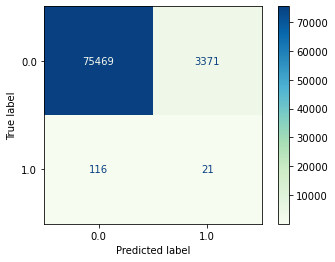

In [67]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds, labels=knn_o_mlp_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_o_mlp_pipe.classes_)
disp.plot(cmap='GnBu')
plt.show()

### Train on full dataset
KNN not suitable for a dataset of this size so multiple imputation needed.

In [41]:
# Optimal Model
fo_svm_model = SVC(C=4, gamma=0.1)

In [43]:
full_svm_o_pipe = imbpipeline(steps = [('imputer', imputer),
                                    ('enc_norm', enc_norm),
                                    ('tomek', tl),
                                    ('smotenc', smote),
                                    ('model', fo_svm_model)])

In [38]:
%%memit

# Model Training
t=Stopwatch()

full_svm_o_pipe.fit(X_train, list(y_train))

print(t.stop())

NameError: name 'full_svm_o_pipe' is not defined

In [ ]:
# Predictions on the test data
full_y_preds = full_svm_o_pipe.predict(X_test)

In [ ]:
full_y_test = list(y_test)

In [ ]:
full_y_preds = full_y_preds.astype('int64')

In [ ]:
# Model evaluation
f1_score(full_y_test, full_y_preds)

In [ ]:
accuracy_score(full_y_test, full_y_preds)

In [ ]:
# Confusion Matrix
full_cm = confusion_matrix(full_y_test, full_y_preds, labels=full_svm_o_pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=full_cm,
                              display_labels=full_svm_o_pipe.classes_)
disp.plot(cmap='GnBu')
plt.show()

#### The model trained on the subset of data outperformed the model trainined on the full dataset

# Save Model

Saving the model trained on the subset pf data which utilised KNN imputation.

In [68]:
model_file = '/data/home/bt211037/dissertation/mlp_model.pkl'

In [69]:
pickle.dump(knn_o_mlp_pipe, open(model_file, 'wb'))